## Inspired by this [post:](https://www.reddit.com/r/dataisbeautiful/comments/hvpv3w/oc_american_war_casualties_death_rate_compared/) comparing Covid to Combat deaths in US

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import urllib.request
from bs4 import BeautifulSoup
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import display,  HTML, Markdown, clear_output
from IPython.core.display import HTML
import ipywidgets as widgets
from matplotlib import pyplot as plt

import re
from datetime import datetime

### Get the data for US Combat Deaths

In [169]:
html_doc = urllib.request.urlopen("https://en.wikipedia.org/wiki/United_States_military_casualties_of_war").read().decode("utf-8")
soup = BeautifulSoup(html_doc, 'html.parser')
war_deaths_table = soup.find_all(class_="wikitable")
header = True
#Create dataframe
war_deaths = pd.DataFrame(columns=['Rank', 'Name', 'Years', 'Deaths', 'Deaths Per Day', 'Population', 'Deaths as % of Pop'])
for war in war_deaths_table[1].find_all('tr'): 
    new_war = []
    if header: 
       header = False
    else: 
        war_data = war.find_all('td')
        death_total =int(war_data[3].text.split(" (est.)")[0].strip().replace(",",""))
        death_per =  float(war_data[6].text.split("%")[0].replace(",",""))
        population = int(war_data[5].text.replace(",",""))
        name = war_data[1].text.replace("American", "")
        war_deaths = war_deaths.append({'Rank': war_data[0].text, 'Name': name, 
                              'Years': war_data[2].text, 'Deaths': death_total
                              , 'Deaths Per Day': float(war_data[4].text), 'Population':population,
                            'Deaths as % of Pop': death_per}, ignore_index=True)
       
war_deaths

,Rank,Name,Years,Deaths,Deaths Per Day,Population,Deaths as % of Pop
0,1,Civil War,1861–65,655000,520.00,31443000,2.083
1,2,World War II,1941–45,405399,297.00,133402000,0.307
2,3,World War I,1917–18,116516,200.00,103268000,0.110
3,4,Vietnam War,1961–75,58209,11.00,179323175,0.032
4,5,Korean War,1950–53,36574,30.00,151325000,0.024
5,6,Revolutionary War,1775–83,25000,11.00,2500000,1.000
6,7,War of 1812,1812–15,15000,15.00,8000000,0.207
7,8,Mexican– War,1846–48,13283,29.00,21406000,0.057
8,9,Iraq War,2003–11,4576,2.00,294043000,0.002
9,10,Philippine– War,1899–1902,4196,3.80,72129001,0.006


### Get the Data for other disease  

https://www.cdc.gov/nchs/data/nvsr/nvsr68/nvsr68_09-508.pdf

In [29]:
#Manually add leading cause of death 2017
top_10_death = pd.DataFrame(columns=["Cause", "Deaths", "Percent"])
top_10_death = top_10_death.append({'Cause':'Heart Disease', 'Deaths': 647457, 'Percent':23}, ignore_index=True)
top_10_death = top_10_death.append({'Cause':'Cancer', 'Deaths': 599108, 'Percent':21.3}, ignore_index=True)
top_10_death = top_10_death.append({'Cause':'Accidents', 'Deaths': 169936, 'Percent':6}, ignore_index=True)
top_10_death = top_10_death.append({'Cause':'Lower Respiratory Disease', 'Deaths': 160201, 'Percent':5.7}, ignore_index=True)
top_10_death = top_10_death.append({'Cause':'Stroke', 'Deaths': 146383, 'Percent':5.2}, ignore_index=True)
top_10_death = top_10_death.append({'Cause':'Alzheimers', 'Deaths': 121404, 'Percent':4.3}, ignore_index=True)
top_10_death = top_10_death.append({'Cause':'Diabetes', 'Deaths': 83564, 'Percent':3.0}, ignore_index=True)
top_10_death = top_10_death.append({'Cause':'Influenza', 'Deaths': 55672, 'Percent':2.0}, ignore_index=True)
top_10_death = top_10_death.append({'Cause':'Nephritis', 'Deaths': 50633, 'Percent':1.8}, ignore_index=True)
top_10_death = top_10_death.append({'Cause':'Suicide', 'Deaths': 47173, 'Percent':1.7}, ignore_index=True)


top_10_death

,Cause,Deaths,Percent
0,Heart Disease,647457,23
1,Cancer,599108,21.3
2,Accidents,169936,6
3,Lower Respiratory Disease,160201,5.7
4,Stroke,146383,5.2
5,Alzheimers,121404,4.3
6,Diabetes,83564,3
7,Influenza,55672,2
8,Nephritis,50633,1.8
9,Suicide,47173,1.7


### Get the Covid Data

In [30]:
# this github repo contains timeseries data for all coronavirus cases: https://github.com/CSSEGISandData/COVID-19
confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data" \
                      "/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"

             
    
date_pattern = re.compile(r"\d{1,2}/\d{1,2}/\d{2}")
def reformat_dates(col_name: str) -> str:
    # for columns which are dates, I'd much rather they were in day/month/year format
    try:
        return date_pattern.sub(datetime.strptime(col_name, "%m/%d/%y").strftime("%m/%d/%Y"), col_name, count=1)
    except ValueError:
        return col_name
    
def resetData():
    renamed_columns_map = {
    "Country/Region": "country",
    "Province_State": "state",
    }

    cols_to_drop = ["Lat", "Long_", "iso2", "iso3", "Admin2", "code3","FIPS", "Country_Region","UID"]

    confirmed_cases_df = (
    pd.read_csv(confirmed_cases_url)
    .rename(columns=renamed_columns_map)
    .rename(columns=reformat_dates)
    .drop(columns=cols_to_drop)
    )
    
    deaths_df = (
    pd.read_csv(deaths_url)
    .rename(columns=renamed_columns_map)
    .rename(columns=reformat_dates)
    .drop(columns=cols_to_drop)
        )
    #confirmed_cases_state_df.loc['US',:] = confirmed_cases_state_df.sum(axis=0)
    return confirmed_cases_df, deaths_df




covid_cases, covid_deaths = resetData()

display(covid_cases.head())
display(covid_deaths.head())
covid_cases = covid_cases.reset_index()

total_deaths = covid_deaths.iloc[:,-1].sum()
total_cases = covid_cases.iloc[:,-1].sum()
total_deaths

top_10_death = top_10_death.append({'Cause':'Covid', 'Deaths': total_deaths}, ignore_index=True)

,state,Combined_Key,01/22/2020,01/23/2020,01/24/2020,01/25/2020,01/26/2020,01/27/2020,01/28/2020,01/29/2020,...,07/14/2020,07/15/2020,07/16/2020,07/17/2020,07/18/2020,07/19/2020,07/20/2020,07/21/2020,07/22/2020,07/23/2020
0,American Samoa,"American Samoa, US",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Guam,"Guam, US",0,0,0,0,0,0,0,0,...,312,313,314,314,314,314,319,319,330,337
2,Northern Mariana Islands,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,...,36,36,37,37,37,37,38,38,38,38
3,Puerto Rico,"Adjuntas, Puerto Rico, US",0,0,0,0,0,0,0,0,...,66,66,66,67,68,72,72,72,72,72
4,Puerto Rico,"Aguada, Puerto Rico, US",0,0,0,0,0,0,0,0,...,58,60,60,66,67,70,71,75,78,82


,state,Combined_Key,Population,01/22/2020,01/23/2020,01/24/2020,01/25/2020,01/26/2020,01/27/2020,01/28/2020,...,07/14/2020,07/15/2020,07/16/2020,07/17/2020,07/18/2020,07/19/2020,07/20/2020,07/21/2020,07/22/2020,07/23/2020
0,American Samoa,"American Samoa, US",55641,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Guam,"Guam, US",164229,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
2,Northern Mariana Islands,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
3,Puerto Rico,"Adjuntas, Puerto Rico, US",19483,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Puerto Rico,"Aguada, Puerto Rico, US",41959,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
top_10_death = top_10_death.sort_values(by='Deaths', ascending=False)
top_10_death

,Cause,Deaths,Percent
0,Heart Disease,647457,23
1,Cancer,599108,21.3
2,Accidents,169936,6
3,Lower Respiratory Disease,160201,5.7
4,Stroke,146383,5.2
10,Covid,144304,NaN
5,Alzheimers,121404,4.3
6,Diabetes,83564,3
7,Influenza,55672,2
8,Nephritis,50633,1.8


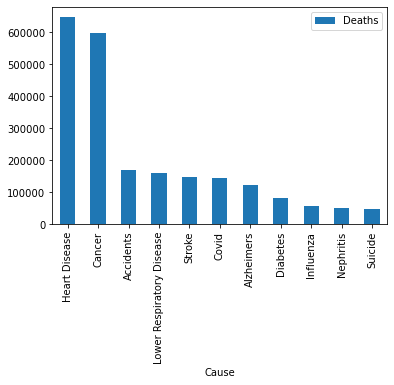

In [35]:
ax = top_10_death.plot.bar(x='Cause', y='Deaths')


In [170]:
#https://www.statista.com/statistics/1109281/covid-19-daily-deaths-compared-to-all-causes/
    
#Hard coded Covid for simplicity from above link
war_deaths = war_deaths.append({'Name': 'Covid', 
                              'Years': '2020', 'Deaths': int(total_deaths)
                              , 'Deaths Per Day': float(920), 'Population': 328000000, 'Deaths as % of Pop': (int(total_deaths)/328000000) * 100 }, ignore_index=True)

war_deaths['Percent Per Day'] = war_deaths['Deaths Per Day']/war_deaths['Population']
#Reduceing Rows for Cleaner graph
war_deaths = war_deaths[war_deaths['Name'] != 'Mexican–American War']
war_deaths = war_deaths[war_deaths['Name'] != 'Philippine–American War']
war_deaths = war_deaths[war_deaths['Name'] != 'Spanish–American War']

war_deaths

,Rank,Name,Years,Deaths,Deaths Per Day,Population,Deaths as % of Pop,Percent Per Day
0,1,Civil War,1861–65,655000,520.00,31443000,2.083000,1.65379e-05
1,2,World War II,1941–45,405399,297.00,133402000,0.307000,2.22635e-06
2,3,World War I,1917–18,116516,200.00,103268000,0.110000,1.93671e-06
3,4,Vietnam War,1961–75,58209,11.00,179323175,0.032000,6.13418e-08
4,5,Korean War,1950–53,36574,30.00,151325000,0.024000,1.98249e-07
5,6,Revolutionary War,1775–83,25000,11.00,2500000,1.000000,4.4e-06
6,7,War of 1812,1812–15,15000,15.00,8000000,0.207000,1.875e-06
7,8,Mexican– War,1846–48,13283,29.00,21406000,0.057000,1.35476e-06
8,9,Iraq War,2003–11,4576,2.00,294043000,0.002000,6.80173e-09
9,10,Philippine– War,1899–1902,4196,3.80,72129001,0.006000,5.26834e-08


In [150]:
war_deaths = war_deaths.sort_values(by='Deaths', ascending=False)
war_deaths

,Rank,Name,Years,Deaths,Deaths Per Day,Population,Deaths as % of Pop,Percent Per Day
0,1,Civil War,1861–65,655000,520.00,31443000,2.08300,1.65379e-05
1,2,World War II,1941–45,405399,297.00,133402000,0.30700,2.22635e-06
12,NaN,Covid,2020,144304,920.00,328000000,0.00044,2.80488e-06
2,3,World War I,1917–18,116516,279.00,103268000,0.11000,2.70171e-06
3,4,Vietnam War,1961–75,58209,11.00,179323175,0.03200,6.13418e-08
4,5,Korean War,1950–53,36574,30.00,151325000,0.02400,1.98249e-07
5,6,Revolutionary War,1775–83,25000,11.00,2500000,1.00000,4.4e-06
6,7,War of 1812,1812–15,15000,15.00,8000000,0.20700,1.875e-06
7,8,Mexican– War,1846–48,13283,29.00,21406000,0.05700,1.35476e-06
8,9,Iraq War,2003–11,4576,2.00,294043000,0.00200,6.80173e-09


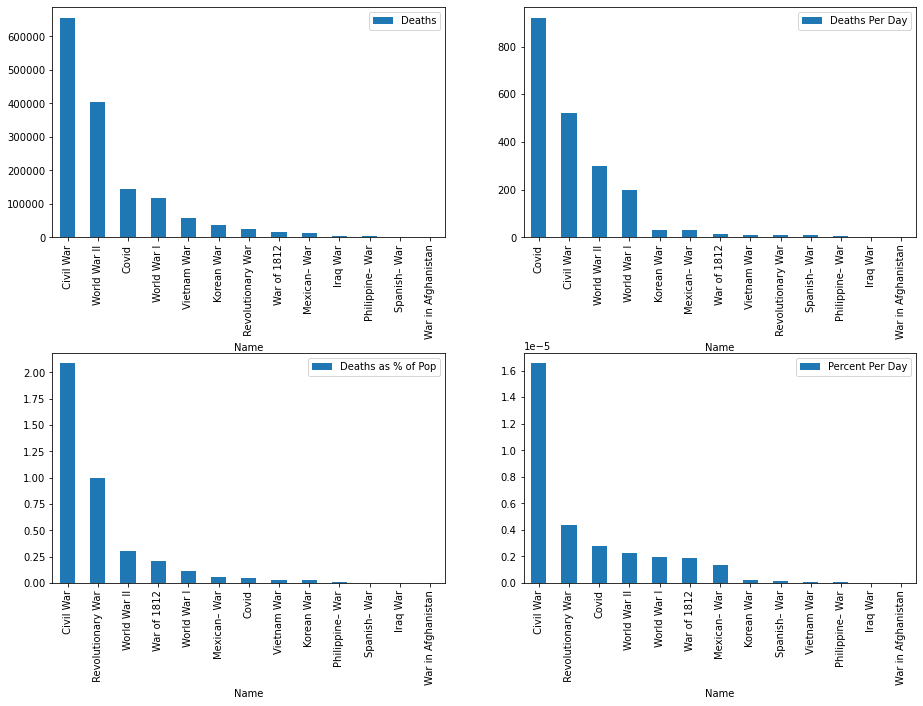

In [171]:
by_deaths = war_deaths.sort_values(by='Deaths', ascending=False)
by_deaths_day = war_deaths.sort_values(by='Deaths Per Day', ascending=False)
by_deaths_percent = war_deaths.sort_values(by='Deaths as % of Pop', ascending=False)
by_deaths_day_percent = war_deaths.sort_values(by='Percent Per Day', ascending=False)

fig = plt.figure()
fig.set_size_inches(15,8)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


#fig.tight_layout(pad=8.0)
fig.subplots_adjust(left=0, bottom=4.0, right=.8, top=5.0, wspace=.2, hspace=.5)

by_deaths.plot.bar(x='Name', y='Deaths', ax=ax1)
by_deaths_day.plot.bar(x='Name', y='Deaths Per Day', ax=ax2)
by_deaths_percent.plot.bar(x='Name', y='Deaths as % of Pop', ax=ax3)
by_deaths_day_percent.plot.bar(x='Name', y='Percent Per Day', ax=ax4)


plt.savefig('covid.png')